# Visual-Analystics Project 2021

## This Project should show how Superheros are correlated with each other and and how we can predict attributes of future Superheros

* The Authors are:
                - Kilian Fay Truong
                - Alexander Riedler
                - Maximilian Hageneder
                
* The used Dataset is:
 [superheroes_nlp_dataset](https://www.kaggle.com/jonathanbesomi/superheroes-nlp-dataset)



### Content
This Notebook is set up as follows:

* Load the Data
* Plot of the dataset
* Clean the dataset
* Some plots for analysis
* Correlation matrix
* PCA, MDS and T-SNE downprojection
* Clustering K-means and Affinity Propagation
* Comparing the original cluster with predicted cluster
* Interpretation

In [1]:
#disable some annoying warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

#plots the figures in place instead of a new window
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import decomposition
from sklearn import manifold
from ipywidgets import interact, interact_manual, interactive
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.tree import DecisionTreeClassifier

import altair as alt

import ipywidgets as widgets

## Load Data

In [2]:
#use a standard dataset of heterogenous data
superheroes = pd.read_csv('data/superheroes_nlp_dataset.csv')
superheroes.head()

,name,real_name,full_name,overall_score,history_text,powers_text,intelligence_score,strength_score,speed_score,durability_score,...,has_flight,has_accelerated_healing,has_weapons_master,has_intelligence,has_reflexes,has_super_speed,has_durability,has_stamina,has_agility,has_super_strength
0,3-D Man,"Delroy Garrett, Jr.","Delroy Garrett, Jr.",6,"Delroy Garrett, Jr. grew up to become a track ...",NaN,85,30,60,60,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,514A (Gotham),Bruce Wayne,NaN,10,He was one of the many prisoners of Indian Hil...,NaN,100,20,30,50,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,A-Bomb,Richard Milhouse Jones,Richard Milhouse Jones,20,"Richard ""Rick"" Jones was orphaned at a young ...","On rare occasions, and through unusual circu...",80,100,80,100,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
3,Aa,Aa,NaN,12,Aa is one of the more passive members of the P...,NaN,80,50,55,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aaron Cash,Aaron Cash,Aaron Cash,5,Aaron Cash is the head of security at Arkham A...,NaN,80,10,25,40,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Clean Data

First we clean the height and weight data as these attributes are given in various units in the same column. Additionally we drop all rows with missing values in either height or weight.

In [3]:
superheroes['height_clean'] = superheroes.height.str.extract(r'(\d+)\s*cm', expand=True)
superheroes['weight_clean'] = superheroes.weight.str.extract(r'(\d+)\s*kg', expand=True)
superheroes['height_clean'] = pd.to_numeric(superheroes['height_clean'], errors='coerce')
superheroes['weight_clean'] = pd.to_numeric(superheroes['weight_clean'], errors='coerce')
superheroes.dropna(subset=['height_clean'], inplace=True)
superheroes.dropna(subset=['weight_clean'], inplace=True)
#superheroes['height_clean'] = superheroes['height_clean'].fillna(superheroes['height_clean'].median())
#superheroes['weight_clean'] = superheroes['weight_clean'].fillna(superheroes['weight_clean'].median())
superheroes['height_clean'] = superheroes['height_clean'].astype('int')
superheroes['weight_clean'] = superheroes['weight_clean'].astype('int')

Now we drop all the 'bad' columns, which only contain text such that we can not process them properly.

In [4]:
superheroes['type_race'] = superheroes['type_race'].fillna('Unknown')
bad_cols = ['name','real_name','full_name','overall_score','history_text',
            'powers_text','superpowers','alter_egos','aliases','place_of_birth',
            'first_appearance','occupation','base','teams','relatives',
            'height','weight','eye_color','hair_color', 'skin_color',
            'img']
superheroes = superheroes[[c for c in superheroes.columns if c not in bad_cols]]

We fill all of the missing power attributes with '0', indicating this hero does not have the power. <br>
We also fill all the missing creators with 'Unknown' and drop all rows which still have missing values.

In [5]:
power_cols = ['has_electrokinesis','has_energy_constructs','has_matter_manipulation', 'has_telepathy_resistance',
            'has_mind_control','has_enhanced_hearing','has_dimensional_travel', 'has_element_control','has_size_changing',
            'has_fire_resistance','has_fire_control','has_dexterity','has_reality_warping','has_illusions','has_energy_beams',
            'has_peak_human_condition','has_shapeshifting','has_jump','has_self-sustenance','has_energy_absorption',
            'has_cold_resistance','has_magic','has_telekinesis','has_toxin_and_disease_resistance','has_telepathy',
            'has_regeneration','has_immortality','has_teleportation','has_force_fields','has_energy_manipulation',
            'has_endurance','has_longevity','has_weapon-based_powers','has_energy_blasts', 'has_enhanced_senses','has_invulnerability',
            'has_stealth','has_marksmanship','has_flight', 'has_accelerated_healing', 'has_weapons_master', 'has_intelligence', 'has_reflexes',
            'has_super_speed','has_durability','has_stamina','has_agility','has_super_strength', 'has_heat_resistance',
            'has_mind_control_resistance']

superheroes[power_cols] = superheroes[power_cols].fillna(0)

superheroes['creator'].fillna('Unknown', inplace=True)
superheroes.dropna(inplace=True)

#with pd.option_context('display.max_rows', None,
#                       'display.max_columns', None,
#                       'display.precision', 3,
#                       ):
#    print(superheroes)
    
#print(superheroes.isnull().any().sum())

Now we calculate a new overall score for each superhero by taking the average of all other score values, and print some rows of our now cleaned data.

In [6]:
score_cols = ['intelligence_score', 'strength_score', 'speed_score', 'durability_score', 'power_score', 'combat_score']
superheroes['overall'] = superheroes[score_cols].sum(axis=1) / 6
#sns.distplot(superheroes['overall'], rug=True)
superheroes

,intelligence_score,strength_score,speed_score,durability_score,power_score,combat_score,creator,alignment,gender,type_race,...,has_intelligence,has_reflexes,has_super_speed,has_durability,has_stamina,has_agility,has_super_strength,height_clean,weight_clean,overall
2,80,100,80,100,100,80,Marvel Comics,Good,Male,Human,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,203,441,90.000000
6,95,30,35,65,100,85,Dark Horse Comics,Good,Male,Icthyo Sapien,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,191,65,68.333333
7,75,90,55,65,100,65,DC Comics,Good,Male,Ungaran,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185,90,75.000000
8,85,100,80,90,100,95,Marvel Comics,Bad,Male,Human / Radiation,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,203,441,91.666667
9,100,10,20,30,100,55,DC Comics,Bad,Male,Human,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,183,77,52.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,100,35,50,60,100,100,Unknown,Good,Male,Android,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,168,45,74.166667
1445,90,10,25,30,100,55,DC Comics,Good,Female,Human,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170,57,51.666667
1446,80,100,100,100,100,80,Capcom,Good,Male,Robot,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,168,65,93.333333
1447,95,50,100,75,100,80,DC Comics,Bad,Male,Unknown,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,185,81,83.333333


## Show Data

To show and understand our data better we created some plots showing the frequencies of attributes. <br>
To save some space we implement a dropdown menu to select which score to plot. 

In [7]:
@widgets.interact(
    Score_type = widgets.Dropdown(
        options = ['intelligence_score', 'speed_score', 'strength_score', 
                   'durability_score', 'power_score', 'combat_score', 'overall']))

def f(Score_type):
    plt.figure(figsize=(14, 10))
    plt.hist(superheroes[f'{Score_type}'])
    plt.xlabel('Score')
    plt.ylabel('No. of Superheroes')
    plt.ylim(0, 700)
    plt.show()

interactive(children=(Dropdown(description='Score_type', options=('intelligence_score', 'speed_score', 'streng…

In the next plot we visualized the relationship between the height and weight of superheroes. <br>
We can clearly see that there are some huge outliers (which might be some false data), but most of the data is reasonable.

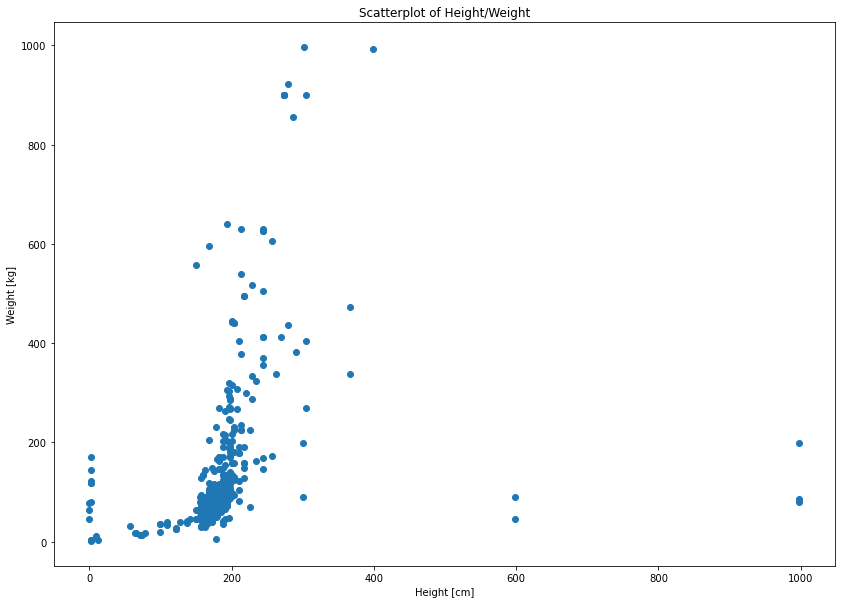

In [8]:
plt.figure(figsize=(14,10))
plt.scatter(x=superheroes['height_clean'], y=superheroes['weight_clean'])
plt.xlabel('Height [cm]')
plt.ylabel('Weight [kg]')
plt.title('Scatterplot of Height/Weight')
plt.show()

There is a feature plot of the different creators: <br>
The two biggest ones, Marvel Comics and DC Comics and all other creators together
* Marvel Comics
* DC Comics
* Other Creators <br>

The coloring depends on wether they are good or bad but there are also some which are neutral

In [9]:
df = superheroes.copy(deep=True)

for i in df.index:
    if df['creator'][i] != 'Marvel Comics' and df['creator'][i] != 'DC Comics':
        df.at[i, 'creator'] = 'Other'


input_dropdown = alt.binding_select(options=['Marvel Comics','DC Comics','Other'], name='Scores')
selection = alt.selection_single(fields=['creator'], bind=input_dropdown)


alt.Chart(df).mark_bar().encode(
    alt.X('overall:Q',bin=True),
    y='count()',
    color='alignment:N',
    tooltip='Name:N'
).properties(
    width=700,
    height=400).add_selection(
    selection
).transform_filter(
    selection
)

alt.Chart(...)

## Plot of the creator with the most published superheroes
### The second plot is without the two biggest creators: Marvel Comics and DC Comics

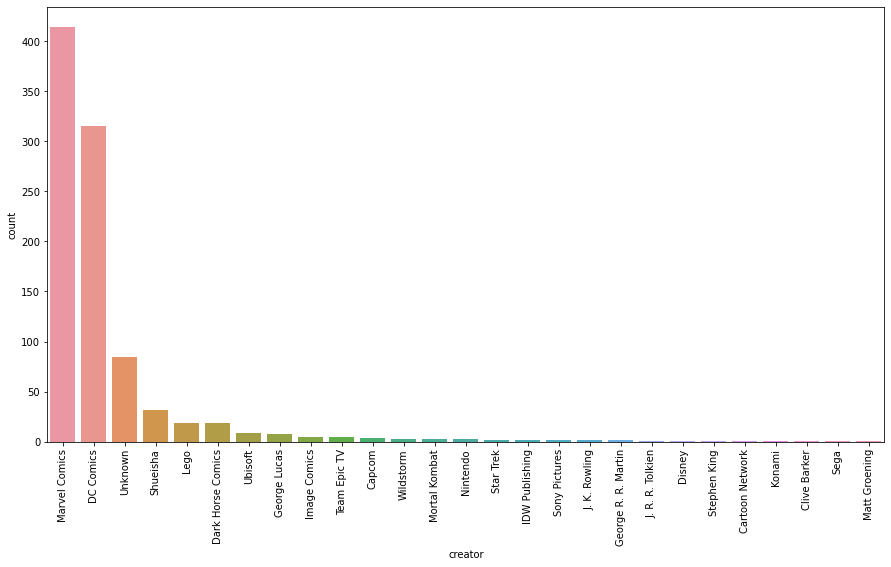

In [10]:
plt.figure(figsize = (15,8))
ax = sns.countplot(superheroes['creator'], order = superheroes['creator'].value_counts().index)
#ax.set_yscale("log")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

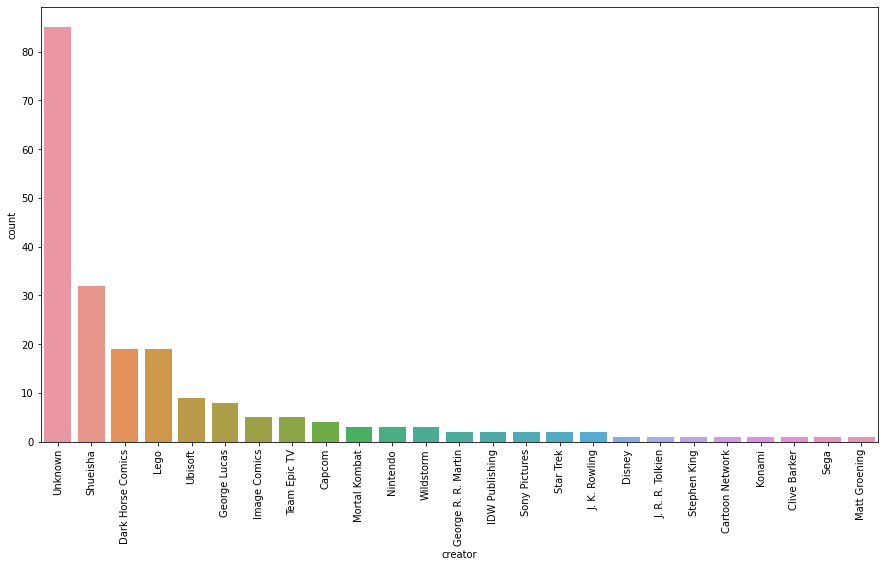

In [11]:
plt.figure(figsize = (15,8))
sh_wo_mdc = superheroes[superheroes.creator != 'Marvel Comics']
sh_wo_mdc = sh_wo_mdc[sh_wo_mdc.creator != 'DC Comics']
ax = sns.countplot(sh_wo_mdc['creator'], order = sh_wo_mdc['creator'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

## Compare of the two bigest Superheores Creators

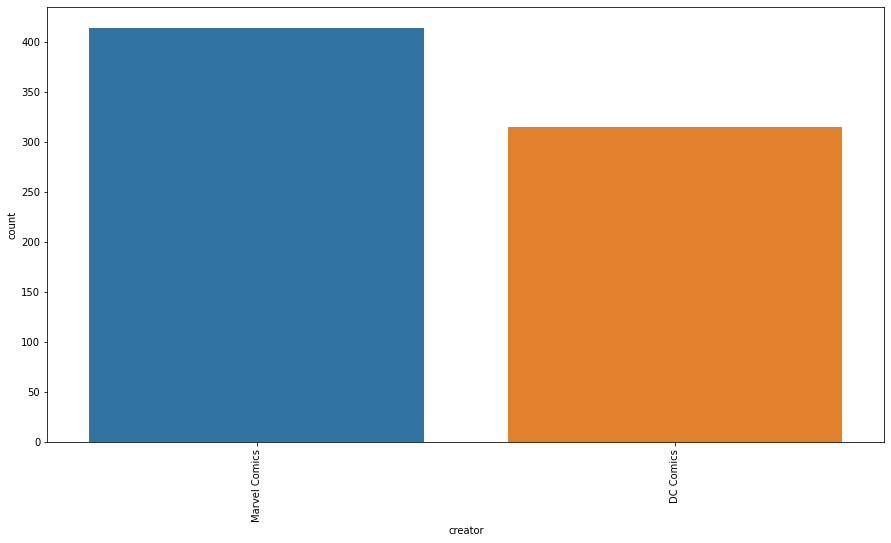

In [12]:
plt.figure(figsize = (15,8))
m1 = superheroes.loc[superheroes.creator == 'Marvel Comics']
m2 = superheroes.loc[superheroes.creator == 'DC Comics']
sh_mdc = pd.concat([m1, m2])
ax = sns.countplot(sh_mdc['creator'])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

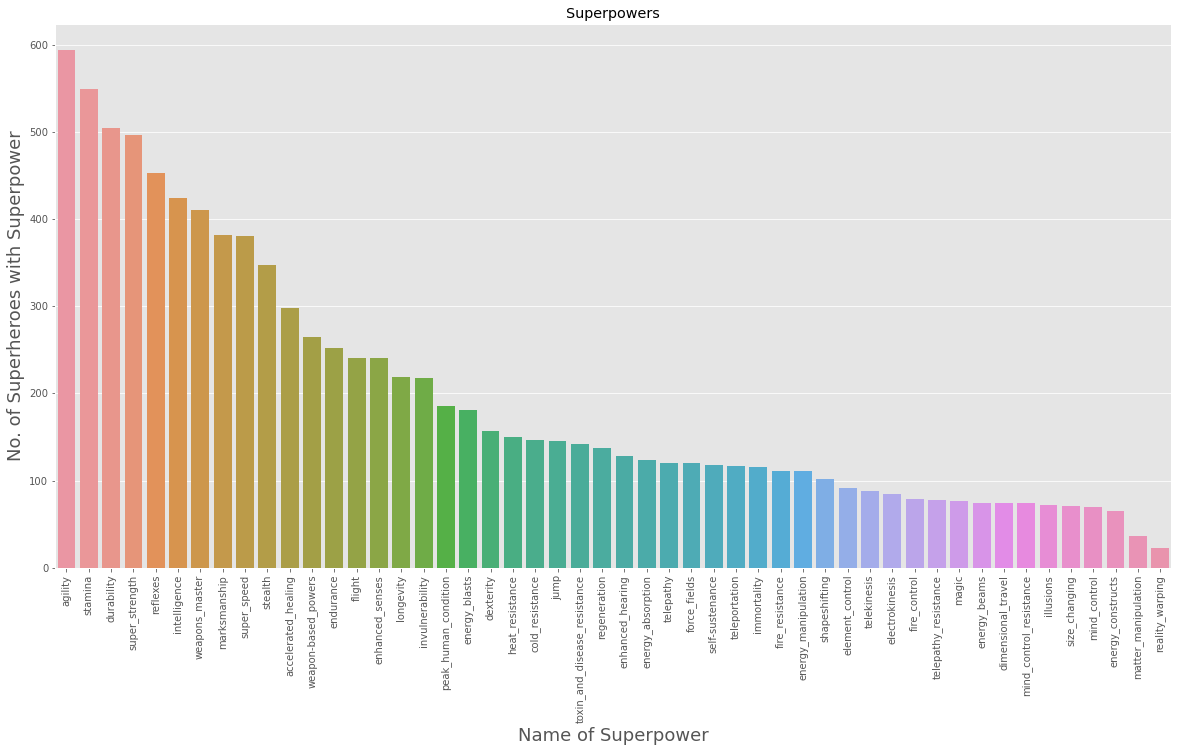

In [13]:
superpowers = superheroes.loc[:, superheroes.columns.str.startswith('has')].dropna()
superpowers.columns = superpowers.columns.str.replace(r'has_', '')
superpowers = superpowers.T.reset_index()
superpowers['Total'] = superpowers.sum(axis=1)
superpowers = superpowers.sort_values('Total',ascending=False)
superpowers.head(1)

plt.style.use('ggplot') # Using ggplot2 style visuals

fig, ax = plt.subplots()

fig.set_size_inches(20, 10)

sns.set_context("paper", font_scale=1.5)
f=sns.barplot(x=superpowers['index'], y=superpowers['Total'], data=superpowers)
f.set_xlabel("Name of Superpower",fontsize=18)
f.set_ylabel("No. of Superheroes with Superpower",fontsize=18)
f.set_title('Superpowers')
for item in f.get_xticklabels():
    item.set_rotation(90)

### The next boxplot shows the distribution of the Power Scores for all superheroes

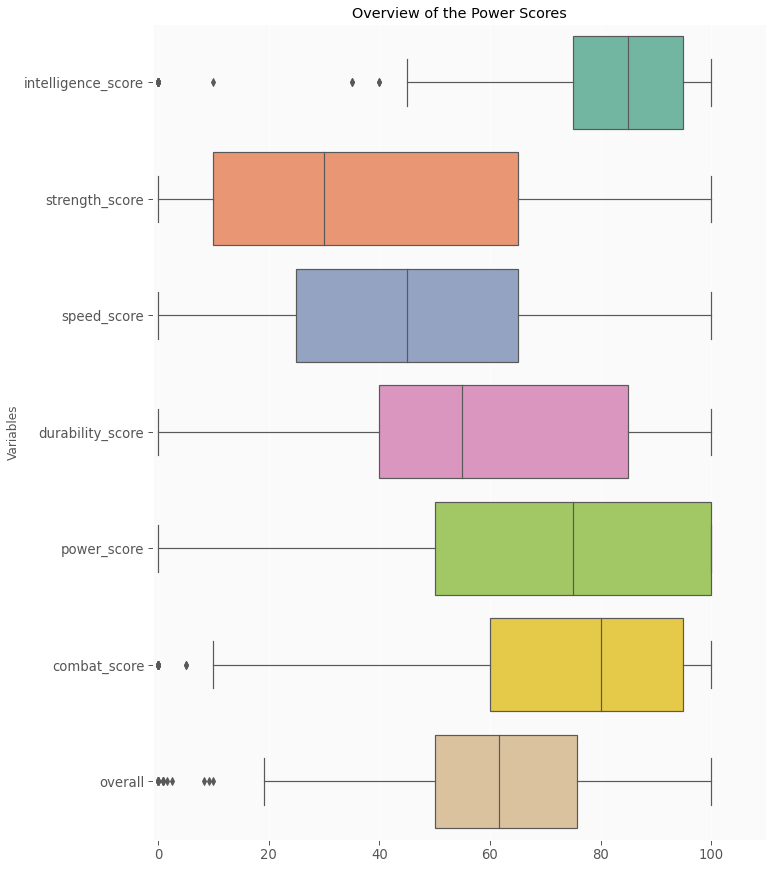

In [14]:
data_x = superheroes[['intelligence_score','strength_score','speed_score','durability_score','power_score','combat_score', 'creator', 'overall']]
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-1, 110))
plt.ylabel('Variables')
plt.title("Overview of the Power Scores")
ax = sns.boxplot(data = data_x, 
  orient = 'h', 
  palette = 'Set2')

## Correlation
To look for correlation between the power scores we calculated the correlation matrix and plotted it as a heatmap. <br>
This plot can be filtered by creators.
### Conclusion
The intelligence and combat scores have nearly no correlation with any other scores. This is even more extreme in the DC Comics Universe<br>
From all of the scores strengh and durability have the highest correlation with each other. <br>
The overall score is obviously highly correlated with the other 6 scores as it is calculated as a mean of all of them

In [15]:
@widgets.interact(
    Universe = widgets.Dropdown(
        options = ['All Creators', 'Marvel Comics', 'DC Comics', 'Others']))

def f(Universe):
    plt.figure(figsize=(14, 10))
    if Universe == 'All Creators':
        heatmap_data = data_x
    elif Universe == 'Others':
        heatmap_data = data_x[data_x.creator != 'Marvel Comics']
        heatmap_data = heatmap_data[heatmap_data.creator != 'DC Comics']
    else:
        heatmap_data = data_x[data_x.creator == Universe]
    sns.heatmap(heatmap_data.corr(), annot=True)
    plt.title(Universe)
    plt.show()

interactive(children=(Dropdown(description='Universe', options=('All Creators', 'Marvel Comics', 'DC Comics', …

### Downprojection and Clustering

In the next cell we downproject all scores of the superheroes with three different methods
* Principal component analysis (PCA)
* Multidimensional scaling (MDS)
* t-distributed stochastic neighbor embedding (TSNE)<br>
***
After that we implement two different clustering methods for each downprojection method.
* K-means Clustering
* Affinity Propagation Clustering<br>
***
We designed the plots to be interactive.
So we can first choose which labels we want:<br>
* Gender
* Creator
* Alignment<br>
***
The second selection is which downprojection and the third which clustering method should be used. With TSNE it is also posible to choose the perplexity.<br>
<br>
It is also possible to make a selection in the plot which allows to inspect a part of the data a bit more closely by showing the distribution of labels in the selected area. 
It also makes the same selection in the other plot so it is easily possible to compare the original labels of the downprojected data with the clustered data.

In [16]:
@widgets.interact(
    dp_label = widgets.Dropdown(
        options = [('Gender', 'gender'), 
                   ('Creator', 'creator'),
                   ('Alignment', 'alignment')],
        description = 'Labels:'),
    dp_type = widgets.Dropdown(
        options = [('PCA', 'pca'),
                   ('TSNE','tsne'),                   
                   ('MDS', 'mds')],
        description = 'Downprojection method:'),
    cluster_type = widgets.Dropdown(
        options = ['K-Means', 'Affinity Propagation'],
        description = 'Clustering method:'))

def selection(dp_label, dp_type, cluster_type):
    brush = alt.selection(type='interval')
    data_downprojection = superheroes.copy()

    data_downprojection = pd.get_dummies(data_downprojection, columns=['type_race'])
    
    if dp_label == 'creator':
        data_downprojection = pd.get_dummies(data_downprojection, columns=['alignment'])
        data_downprojection = pd.get_dummies(data_downprojection, columns=['gender'])        
        for i in data_downprojection.index:
            if data_downprojection['creator'][i] != 'Marvel Comics' and data_downprojection['creator'][i] != 'DC Comics':
                data_downprojection.at[i, 'creator'] = 'Other'
    elif dp_label == 'alignment':
        data_downprojection = pd.get_dummies(data_downprojection, columns=['gender'])
        data_downprojection = pd.get_dummies(data_downprojection, columns=['creator'])
    else: #'gender'
        data_downprojection = pd.get_dummies(data_downprojection, columns=['alignment'])
        data_downprojection = pd.get_dummies(data_downprojection, columns=['creator'])        
            
    data_downprojection.rename(columns={dp_label : 'labels'}, inplace = True)
       
    if dp_type == 'tsne':
        @interact_manual(
            perplexity=(1,50),
            n_components = widgets.IntSlider(value = 4, min =2, max = 6, step = 1),
            n_clusters = widgets.IntSlider(value = 2, min =2, max = 6, step = 1),
            feature_1 = widgets.Dropdown(
                options = list(data_downprojection.columns),
                value = 'height_clean',
                description = 'feature_1'),
            feature_2 = widgets.Dropdown(
                options = list(data_downprojection.columns),
                value = 'weight_clean',
                description = 'feature_2')
        )     
        def show_tsne(perplexity, n_clusters, feature_1, feature_2):
            #print(perplexity)
            data_tsne = pd.DataFrame()
            tsne = manifold.TSNE(n_components=2, perplexity = perplexity)

            pos = tsne.fit_transform(data_downprojection.drop('labels', axis = 1))

            data_tsne['tsne_x'] = pos[:, 0]
            data_tsne['tsne_y'] = pos[:, 1]
            data_tsne['labels'] = data_downprojection['labels']
            data_tsne.dropna(inplace = True)
            if cluster_type == 'K-Means':
                kmeans = KMeans(n_clusters=n_clusters, random_state = 102)
                data_tsne['predict'] = kmeans.fit_predict(data_tsne.drop('labels', axis = 1))
            else:
                affinity = AffinityPropagation(random_state=5)
                af = affinity.fit(data_tsne.drop('labels', axis = 1))
                print(len(af.cluster_centers_indices_))
                data_tsne['predict'] = af.labels_
                
            point = alt.Chart(data_tsne).mark_circle().encode(
                x='tsne_x:Q',
                y='tsne_y:Q', 
                color=alt.condition(brush, 'labels:N', alt.value('lightgray'))).properties(height=500, width=750, title=f'T-SNE {cluster_type}'
                                                                 ).add_selection(brush) 
            bar = alt.Chart(data_tsne).mark_bar().encode(
                y='labels:N',
                color='labels:N',
            x='count(labels):Q').transform_filter(brush)
                
                
            clustering_tsne_point = alt.Chart(data_tsne).mark_point().encode(
                x='tsne_x', 
                y='tsne_y', 
                color=alt.condition(brush,'predict:N', alt.value('lightgray'))).properties(height=500, width=750, title=f'T-SNE {cluster_type}').add_selection(brush)
            
            clustering_tsne_bar = alt.Chart(data_tsne).mark_bar().encode(
                y='labels:N',
                color='predict:N',
                x='count(predict):Q').transform_filter(brush)                
            
            if cluster_type == 'K-Means':
                data_downprojection['prediction'] = kmeans.predict(tsne.fit_transform(data_downprojection.drop('labels', axis = 1)))
            else:
                data_downprojection['prediction'] = affinity.predict(tsne.fit_transform(data_downprojection.drop('labels', axis = 1)))


            actual = alt.Chart(data_downprojection).mark_point().encode(
                x = feature_1 + ':N',
                y = feature_2 + ':N',
                color = 'labels:N').properties(height=500, width=750, title='Data with actual labels')

            predictions = alt.Chart(data_downprojection).mark_point().encode(
                x = feature_1 + ':N',
                y = feature_2 + ':N',
                color = 'prediction:N').properties(height=500, width=750, title='Data with predicted labels')


            return (point & bar & actual | clustering_tsne_point & clustering_tsne_bar & predictions) 
            
    elif dp_type == 'mds':
        @interact_manual(
            n_components = widgets.IntSlider(value = 4, min =2, max = 6, step = 1),
            n_clusters = widgets.IntSlider(value = 2, min =2, max = 6, step = 1)
        )
        def prep_mds(n_components, n_clusters):
            components = []
            for i in range(n_components):
                components.append(i)
            @interact(
                d1 = widgets.Dropdown(
                    options = [x for x in components],
                    description = 'Component 1:'),
                d2 = widgets.Dropdown(
                    options = [x for x in components],
                    value = 1,
                    description = 'Component 2:'),
                feature_1 = widgets.Dropdown(
                    options = list(data_downprojection.columns),
                    value = 'height_clean',
                    description = 'feature_1'),
                feature_2 = widgets.Dropdown(
                    options = list(data_downprojection.columns),
                    value = 'weight_clean',
                    description = 'feature_2')
            )
            def show_mds(d1, d2, feature_1, feature_2):
                data_mds = pd.DataFrame()
                mds = manifold.MDS(n_components=n_components, random_state=5)
                pos = mds.fit_transform(data_downprojection.drop('labels', axis = 1))

                data_mds['mds_x']= pos[:, 0]
                data_mds['mds_y']= pos[:, 1]
                data_mds['labels'] = data_downprojection['labels']
                data_mds.dropna(inplace = True)

                if cluster_type == 'K-Means':
                    kmeans = KMeans(n_clusters=n_clusters, random_state = 102)
                    data_mds['predict'] = kmeans.fit_predict(data_mds.drop('labels', axis = 1))
                else:
                    affinity = AffinityPropagation(random_state=5)
                    data_mds['predict'] = affinity.fit_predict(data_mds.drop('labels', axis = 1))


                point = alt.Chart(data_mds).mark_circle().encode(
                    x='mds_x:Q',
                    y='mds_y:Q', 
                    color=alt.condition(brush, 'labels:N', alt.value('lightgray'))).properties(height=500, width=750, title=f'MDS {cluster_type}'
                                                                         ).add_selection(brush) 
                bar = alt.Chart(data_mds).mark_bar().encode(
                    y='labels:N',
                    color='labels:N',
                    x='count(labels):Q').transform_filter(brush)


                clustering_mds_point = alt.Chart(data_mds).mark_point().encode(
                    x='mds_x', 
                    y='mds_y', 
                    color=alt.condition(brush,'predict:N', alt.value('lightgray'))).properties(height=500, width=750, title=f'MDS {cluster_type}').add_selection(brush)
                clustering_mds_bar = alt.Chart(data_mds).mark_bar().encode(
                    y='labels:N',
                    color='predict:N',
                    x='count(predict):Q').transform_filter(brush)                


                if cluster_type == 'K-Means':
                    data_downprojection['prediction'] = kmeans.predict(mds.fit_transform(data_downprojection.drop('labels', axis = 1))[:, [d1,d2]])
                else:
                    data_downprojection['prediction'] = affinity.predict(mds.fit_transform(data_downprojection.drop('labels', axis = 1))[:, [d1,d2]])


                actual = alt.Chart(data_downprojection).mark_point().encode(
                    x=feature_1+':N',
                    y=feature_2+':N',
                    color='labels:N').properties(height=500, width=750, title='Data with actual labels')

                predictions = alt.Chart(data_downprojection).mark_point().encode(
                    x=feature_1+':N',
                    y=feature_2+':N',
                    color='prediction:N').properties(height=500, width=750, title='Data with predicted labels')


                return (point & bar & actual | clustering_mds_point & clustering_mds_bar & predictions) 

    else: #pca
        @interact_manual(
            n_components = widgets.IntSlider(value = 4, min =2, max = 6, step = 1),
            n_clusters = widgets.IntSlider(value = 2, min =2, max = 6, step = 1)
        )
        def prep_pca(n_components, n_clusters):
            components = []
            for i in range(n_components):
                components.append(i)
            @interact(
                d1 = widgets.Dropdown(
                    options = [x for x in components],
                    description = 'Component 1:'),
                d2 = widgets.Dropdown(
                    options = [x for x in components],
                    value = 1,
                    description = 'Component 2:'),
                feature_1 = widgets.Dropdown(
                    options = list(data_downprojection.columns),
                    value = 'height_clean',
                    description = 'feature_1'),
                feature_2 = widgets.Dropdown(
                    options = list(data_downprojection.columns),
                    value = 'weight_clean',
                    description = 'feature_2')
            )
            def show_pca(d1, d2, feature_1, feature_2):
                data_pca = pd.DataFrame()
                pca = decomposition.PCA(n_components=n_components)
                pos = pca.fit_transform(data_downprojection.drop('labels', axis = 1))
                data_pca['pca_x']= pos[:, d1]
                data_pca['pca_y']= pos[:, d2]
                data_pca['labels'] = data_downprojection['labels']
                data_pca.dropna(inplace = True)

                if cluster_type == 'K-Means':
                    kmeans =KMeans(n_clusters=n_clusters, random_state = 102)
                    data_pca['predict'] = kmeans.fit_predict(data_pca.drop('labels', axis = 1))
                else:
                    affinity = AffinityPropagation(random_state=5)
                    data_pca['predict'] = affinity.fit_predict(data_pca.drop('labels', axis = 1))

                point = alt.Chart(data_pca).mark_circle().encode(
                    x='pca_x:Q',
                    y='pca_y:Q', 
                    color=alt.condition(brush, 'labels:N', alt.value('lightgray'))).properties(height=500, width=750, title=f'PCA'
                                                                         ).add_selection(brush) 
                bar = alt.Chart(data_pca).mark_bar().encode(
                    y='labels:N',
                    color='labels:N',
                    x='count(labels):Q').transform_filter(brush)

                clustering_pca_point = alt.Chart(data_pca).mark_point().encode(
                    x='pca_x', 
                    y='pca_y', 
                    color=alt.condition(brush,'predict:N', alt.value('lightgray'))).properties(height=500, width=750, title=f'PCA {cluster_type}').add_selection(brush)
                
                clustering_pca_bar = alt.Chart(data_pca).mark_bar().encode(
                    y='labels:N',
                    color='predict:N',
                    x='count(predict):Q').transform_filter(brush)
                
                if cluster_type == 'K-Means':
                    data_downprojection['prediction'] = kmeans.predict(pca.fit_transform(data_downprojection.drop('labels', axis = 1))[:, [d1,d2]])
                else:
                    data_downprojection['prediction'] = affinity.predict(pca.fit_transform(data_downprojection.drop('labels', axis = 1))[:, [d1,d2]])
                
                
                actual = alt.Chart(data_downprojection).mark_point().encode(
                    x=feature_1+':N',
                    y=feature_2+':N',
                    color='labels:N').properties(height=500, width=750, title='Data with actual labels')
                
                predictions = alt.Chart(data_downprojection).mark_point().encode(
                    x=feature_1+':N',
                    y=feature_2+':N',
                    color='prediction:N').properties(height=500, width=750, title='Data with predicted labels')


                return (point & bar & actual | clustering_pca_point & clustering_pca_bar & predictions) 

interactive(children=(Dropdown(description='Labels:', options=(('Gender', 'gender'), ('Creator', 'creator'), (…

C:\Users\kilia\.conda\envs\VA\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


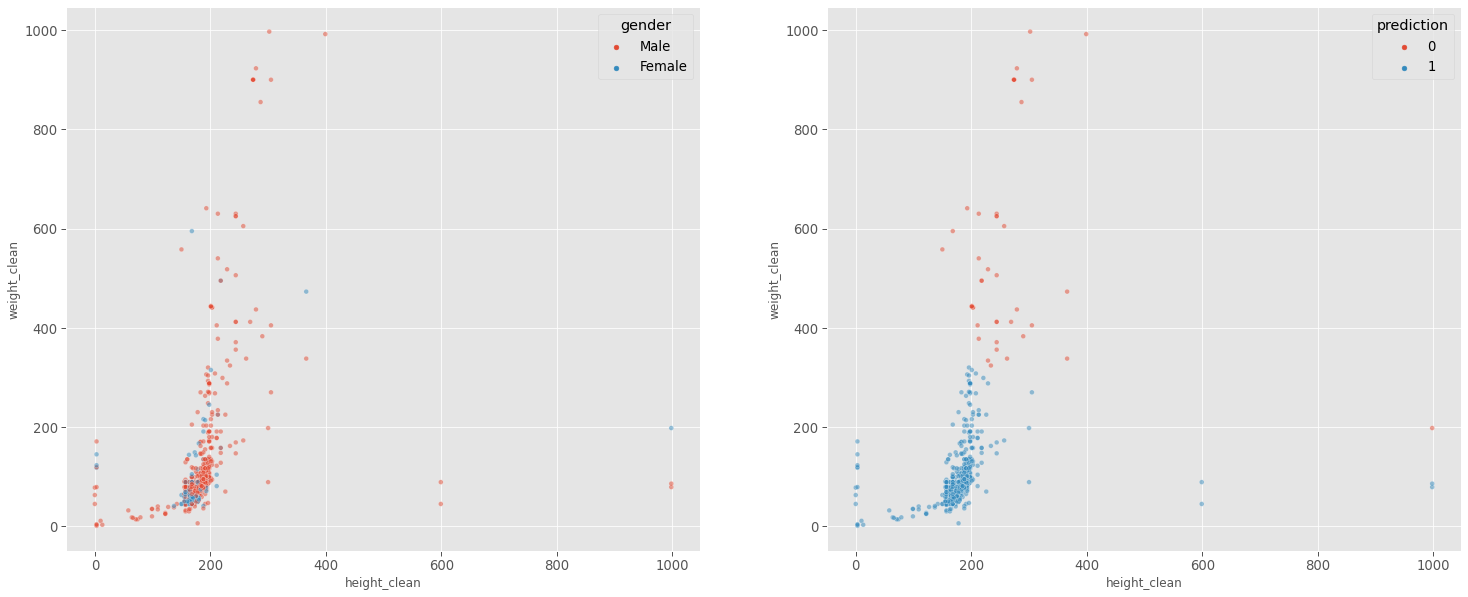

In [17]:
data_clustering = superheroes[['height_clean', 'weight_clean', 'gender']]
kmeans = KMeans(n_clusters=2, random_state = 102)
data_clustering.loc[:, 'prediction'] = kmeans.fit_predict(data_clustering.drop('gender', axis = 1))
fig, axes = plt.subplots(1, 2, figsize=(25,10))
sns.scatterplot(ax = axes[0], x='height_clean', y='weight_clean', hue='gender', data = data_clustering, alpha=0.5)
sns.scatterplot(ax = axes[1], x='height_clean', y='weight_clean', hue='prediction', data = data_clustering, alpha=0.5)
plt.show()

## Interpretation 

***
### Principal component analysis (PCA)

The PCA with the original labels shows that the data has mostly random weigths, because of this the PCA k-means clustering shows completely wrong clusters, meaning this data cannot be used properly.

The height and weight produce some nice clusters, maybe there are some outliers but it could work.
In the prediction for height and weight we can see that it cannot predict the correct labels.
This is also a problem because the heights/weigths are also somewhat random. (Removing the biggest outliers also does not provide any benefits.)
***
### Multidimensional scaling (MDS)

Using MDS it shows that it has the same issue as PCA, where it just forms one big cluster when using k-means clustering.
On the other hand, when using affinity propagation as a clustering method, it forms way to many clusters, 31 to be exact, which is not that useful either.
***
### t-distributed stochastic neighbor embedding (TSNE)

Using TSNE with k-means clustering, we can see that the prediction is simply formed by a straight line right through the middle of the cluster.
As we have already seen with MDS, using TSNE with affinity propagation clustering again forms way to many clusters, although not as many as MDS, but still to many to be useful in the future.